# Scoring a model and logging the results to Weight and Biases

This notebook demonstrates how to score your model on the test_2022 dataset and upload the results to Weights and Biases (wandb).

Before being able to upload your results to wandb, you will need to be added to the wandb team set up for this project. Please contact the research engineering team for this.

You will also need to have downloaded or have access to the test_2022 dataset - it is available in Baskerville in the shared data folder. 

### Step 1. Create a class to run your model

In this notebook we'll make a blurry persistence baseline model. This model will take the most recent satellite image, apply some gaussian blur, and then predict this same blurry image for the future time steps. 

This is a somewhat contrived example, a better baseline likely wouldn't blur the image before projecting it into the future. However, this version will allow us to show the working of the library better. The normal version of persistence is a little too simple to show things effectively

In [1]:
# First we'll load a sample from the dataset. We'll use this sample later
from cloudcasting.dataset import SatelliteDataset

dataset = SatelliteDataset(
    zarr_path="path/to/satellite/data/2020_nonhrv.zarr",
    start_time="2020-06-01",
    end_time="2020-06-15",
    history_mins=0,
    forecast_mins=180,
    sample_freq_mins=15,
)

# Grab a single sample
X, y = dataset[1000]

#### - Quick detour: Lets show what the blur part of this persistence model actually does

This isn't particularly important, so feel free to skip this


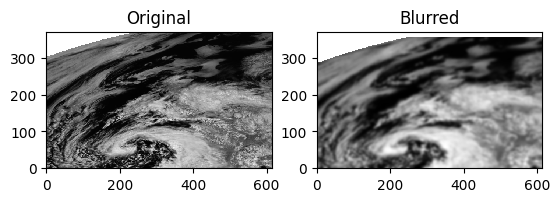

In [2]:
# We'll use scipy to blur the image
from scipy.ndimage import gaussian_filter

# We blur only on the last 2 axes, the spatial dimensions, rather than bluring across time and
# satellite channels also
X_blur = gaussian_filter(X, sigma=3, axes=(-2,-1))


# Here a comparison of the original and blurred images
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(X[8, 0, :, ::-1], cmap='gist_grey', interpolation='nearest', origin="lower")
ax2.imshow(X_blur[8, 0, :, ::-1], cmap='gist_grey', interpolation='nearest', origin="lower")

ax1.set_title("Original")
ax2.set_title("Blurred")
plt.show()

#### - Back to the important bits

The testing process requires that your model accepts inputs and produces outputs with a certain structure.

You will need to write a class for your model which inherits from the `AbstractModel` class from `cloudcasting.models`. 

This can be done after you train your model, its just a little wrapper around your model to make sure your model works with the validation process

In [3]:
# We import the AbstractModel class
# For our persisentence model we'll also need numpy and scipy
import numpy as np
from scipy.ndimage import gaussian_filter

from cloudcasting.models import AbstractModel

Now we'll define our model class. You will need to:

- Use the `__init__()` method to set up your model.
  - This might include loading a trained ML model from disk or assigning parameters to `self`

- Define the `forward()` method. 
  - This is how your model actually makes predictions. 
  - It should accept a numpy array with shape `(batch_size, channels, time_in, height, width)` 
  - and return a numpy array with shape `(batch_size, channels, time_out, height, width)`
  - All of the returned values should be in the range [0, 1], which the code will check for you

- Define the `hyperparameters_dict()` method. 
  - This method must return a dictionary. 
  - The values in this dictionary will be logged to wandb alongside your model's scores. 
  - This is just for your conveniene to remember which version of the model these scores belong to. 
  - You could log the number of layers you used in some component of a neural network, or some parameters used in optical flow, or even just a version number of your network.

In [4]:
# We define a new class that inherits from AbstractModel
class BlurryPersistenceModel(AbstractModel):
    """A persistence model which predicts a blury version of the most recent frame"""

    def __init__(self, history_steps: int, sigma: float) -> None:
        # All models must include `history_steps` as a parameter. This is the number of previous
        # frames that the model uses to makes its predictions. This should not be more than 25, i.e.
        # 6 hours (inclusive of end points) of 15 minutely data

        # You also must inlude the following line in your init function
        super().__init__(history_steps)


        ###### YOUR CODE HERE ######
        # Here you can add any other parameters that you need to initialize your model
        # You might load your trained ML model or set up an optical flow method here

        # For this model, we just store the sigma value which controls the amount of blurring
        self.sigma = sigma

        ############################


    def forward(self, X):
        # This is where you will make predictions with your model
        # The input X is a numpy array with shape (batch_size, channels, time, height, width)

        ###### YOUR CODE HERE ######

        # Grab the most recent frame from the input data
        latest_frame = X[:, :, -1:, :, :]

        # Blur the frame
        blurred_frame = gaussian_filter(latest_frame, sigma=self.sigma, axes=(-2,-1))

        # There can be NaNs in the input data, so will need to replace them with zeros
        blurred_frame = np.nan_to_num(blurred_frame, nan=0.0)

        # Predict the same blurred frame for the next 12 time steps
        # This is the next 3 hours at 15 minute intervals
        y_hat = np.repeat(blurred_frame, repeats=12, axis=2)

        # Clip the values to be between 0 and 1
        y_hat = y_hat.clip(0, 1)

        ############################

        return y_hat

    def hyperparameters_dict(self):

        # This function should return a dictionary of hyperparameters for the model
        # This is just for your own reference and will be saved with the model scores to wandb

        ###### YOUR CODE HERE ######

        params_dict =  {
            "sigma": self.sigma,
            "persistence_type": "blurry",
            "model_vibe": "bad",
        }

        ############################

        return params_dict

Next we'll make sure that the model class we created works

In the cell below, calling `model(x)` will internally call the `forward()` method of the model. It also performs some additional checks to make sure there are no NaNs of values outside of range in the 

In [5]:
# Instantiate the model
model = BlurryPersistenceModel(
    history_steps=1,   # We only need the single most recent frame
    sigma=3,           # We'll blur the image with a sigma of 3
)

# Make sure the hyperparameters_dict method works
print(model.hyperparameters_dict())

# Make sure the forward method works
y_hat = model(X[np.newaxis, ...]) # we use X[np.newaxis, ...] to add a batch dimension

{'sigma': 3, 'persistence_type': 'blurry', 'model_vibe': 'bad'}


### Step 2. Evaluate the model

All the hard work should be behind us now. All we need to do is run the `validate` function on our model. The `validate` function in `cloudcasting.validation` runs the given model on all of the samples in the test_2022 dataset, calculates some metrics and logs the results to weights and biases.

In [6]:
# Import the validate function
from cloudcasting.validation import validate

# Define the wandb project and run name where the results will be logged

# The wandb project is essentially the folder where the results will be stored on wandb.
# You should log your results to the "cloudcasting" folder. However, you can create a new project
# just for your owen results if you want to keep them separate from the main project. To create your
# own project, just change the WANDB_PROJECT variable to a new name.
WANDB_PROJECT = "cloudcasting"


# The wandb run name is the name that this specific call of the validate function will be logged
# under within the project. You can change this to whatever you like.
WANDB_RUN_NAME = "blurry-persistence-v1"

In the `validate()` function we pass in:

- The model object

- The path to the 2022 test dataset

- The project and run name

- The batch limit. This will limit the number of batches that the model is scored on. This should be set to `None` unless you just want to test that your model works. If you set this to a value other than None, your run-name will be changed to reflect the fact that it has only been run on a subset of the test batches and we won't be able to fairly compare the model's results to other models which have run the full set

- The batch size and number of workers. This is the batch size and number of parallel workers used to load batches of satellite data from disk. If `num_workers=0` then no parallel processes are used.

Note that there are 14,949 samples in the test_2022 dataset so the validate function may take some time to run for all of them. In this notebook we'll only run 20 batches of batch_size 2 - so 40 samples

In [7]:
validate(
    model=model,
    data_path="path/to/satellite/data/test_2022.zarr",
    wandb_project_name=WANDB_PROJECT,
    wandb_run_name=WANDB_RUN_NAME,
    batch_size = 2,
    num_workers = 0,
    batch_limit = 20,  # We limit the number of batches to 20 for this example
)

2024-08-23 12:47:25,564 - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: james_ocf (openclimatefix). Use `wandb login --relogin` to force relogin
100%|██████████| 20/20 [01:14<00:00,  3.73s/it]
wandb: Currently logged in as: james_ocf (manchester_prize). Use `wandb login --relogin` to force relogin


The validation process has completed. You can now click the link above to see the results